contribution: Navami Raj

# **Facial images Classification (with/without glasses)**

This notebook focuses on classifying facial images into two categories:
With Glasses (label 0) and Without Glasses (label 1).

*Dataset*

*   Dataset used is from[XAI DatasetCollection](https://xaidataset.github.io/dataset/#face-glasses-recognition-(glasses-xai)
*   Contain total 2614 images, equally split between
  *   Glasses(0): 1307 images
  *   Non-glasses(1): 1307 images

*Model*

A ResNet18 architecture was used for classification. After training, the model achieved an  accuracy of 99% on the test dataset.

# **Training the model**

In [5]:
import random
import os
import shutil
import cv2
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchvision import transforms
from torch import nn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [6]:
glass_list = os.listdir('glasses/glasses/image/pos')
noglass_list = os.listdir('glasses/glasses/image/neg')
print("Glass:",len(glass_list))
print("No glass:",len(noglass_list))

Glass: 1307
No glass: 1307


Dataset is split into train(75%), val(15%) and test(10%)

In [7]:
#split 75:15:10
def split_data(lists):
    random.shuffle(lists)
    train_end = int(0.75 * len(lists))
    val_end = train_end + int(0.15 * len(lists))
    train = lists[:train_end]
    val = lists[train_end:val_end]
    test = lists[val_end:]

    return train, val, test

print('Spliting the data for train(75%), val(15%) and test(10%)')
glass_train, glass_val, glass_test = split_data(glass_list)
noglass_train, noglass_val, noglass_test = split_data(noglass_list)
print(f"Train: {len(glass_train+noglass_train)}")
print(f"Val: {len(glass_val+noglass_val)}")
print(f"Test: {len(glass_test+noglass_test)}")

Spliting the data for train(75%), val(15%) and test(10%)
Train: 1960
Val: 392
Test: 262


Loading RestNet pre-trained modelto train the model

In [ ]:
#load ResNet18 model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) # final layer to classify glasses and no glasse

DataLoader for train, val and test datas

In [9]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='glasses/data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = datasets.ImageFolder(root='glasses/data/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.ImageFolder(root='glasses/data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [10]:
#Label index
print(train_dataset.class_to_idx)  # {'glass': 0, 'noglass': 1}
class_name = {0: 'glass', 1: 'noglass'}

{'glass': 0, 'noglass': 1}


Evaluation and metrics

In [ ]:
#Evaluation and metrics
def evaluate(model, loader, metrics):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")
    if metrics:
      all_preds = torch.cat(all_preds).numpy()
      all_labels = torch.cat(all_labels).numpy()

      print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}\n")
      print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}\n")
      print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}\n")
      print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}\n")
      print(f"Classification Report:\n{classification_report(all_labels, all_preds)}")


Training Function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, epochs=5):
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm.tqdm(train_loader):
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Statistics
      running_loss += loss.item()
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

    #validation
    evaluate(model, val_loader, False)

In [ ]:
train_model(model, train_loader, epochs=3)

100%|██████████| 123/123 [05:38<00:00,  2.75s/it]


Epoch 1/3 | Loss: 8.1927 | Train Acc: 97.55%


100%|██████████| 49/49 [01:36<00:00,  1.98s/it]


Validation Accuracy: 1.00%



100%|██████████| 123/123 [01:07<00:00,  1.82it/s]


Epoch 2/3 | Loss: 1.0854 | Train Acc: 99.85%


100%|██████████| 49/49 [00:10<00:00,  4.56it/s]


Validation Accuracy: 1.00%



100%|██████████| 123/123 [01:06<00:00,  1.84it/s]


Epoch 3/3 | Loss: 0.4065 | Train Acc: 99.95%


100%|██████████| 49/49 [00:10<00:00,  4.62it/s]

Validation Accuracy: 1.00%



In [ ]:
evaluate(model, test_loader, True)

100%|██████████| 49/49 [01:37<00:00,  1.98s/it]

Validation Accuracy: 1.00%

F1 Score: 0.9974

Precision: 0.9975

Recall: 0.9974

Confusion Matrix:
[[196   0]
 [  1 195]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       196
           1       1.00      0.99      1.00       196

    accuracy                           1.00       392
   macro avg       1.00      1.00      1.00       392
weighted avg       1.00      1.00      1.00       392



In [ ]:
torch.save(model.state_dict(), "glasses.pt")

# **Apply XAI methods**

In this project, we used four XAI techniques to interpret our image classification model:

1. Grad-CAM
2. LIME
3. Integrated Gradients
4. Occulation Technique

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load the train model

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("glasses.pt"))
model.to(device)
model.eval()

**1. GradCAM**

**GradCAM** visualizes the regions in the image that the model focuses on to make its prediction, using the gradients flowing into the final convolutional layer.

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [16]:
to_pil = transforms.ToPILImage()
#with glass
glass_image = to_pil(test_dataset[70][0])
glass_image = glass_image.resize((512, 512), resample=Image.Resampling.BILINEAR)
glass_image_np = np.array(glass_image)
glass_input_tensor = transform(glass_image).unsqueeze(0).to(device)

#no glass
noglass_image = to_pil(test_dataset[257][0])
noglass_image = noglass_image.resize((512, 512), resample=Image.Resampling.BILINEAR)
noglass_image_np = np.array(noglass_image)
noglass_input_tensor = transform(noglass_image).unsqueeze(0).to(device)

target_layer = model.layer4[-1]

cam = GradCAM(model=model, target_layers=[target_layer])

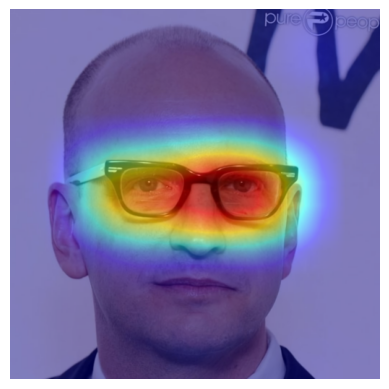

In [17]:
grayscale_cam_glass = cam(input_tensor=glass_input_tensor)[0, :]
visualization_glass = show_cam_on_image(glass_image_np / 255.0, grayscale_cam_glass, use_rgb=True)
plt.axis('off')
plt.imshow(visualization_glass)

**Interpretation**: Heatmap strongly focuses around the glasses area (frames and bridge), indicate where the model focuses when predicting the presence of glasses.

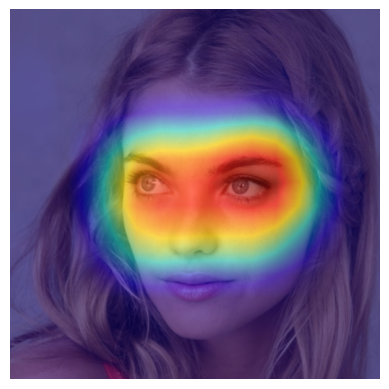

In [18]:
grayscale_cam_noglass = cam(input_tensor=noglass_input_tensor)[0, :]
visualization_noglass = show_cam_on_image(noglass_image_np / 255.0, grayscale_cam_noglass, use_rgb=True)
plt.axis('off')
plt.imshow(visualization_noglass)

 **Interpretation**: The model seems to check the eye region to verify the absence/presence of glass.

**2. LIME**

**LIME**(Local Interpretable Model-agnostic Explanations) highlights which parts of an image influenced the model’s prediction by masking regions and observing changes.
It shows what the model "looked at" to make its decision.

In [19]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [20]:
explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    model.eval()
    images = torch.stack([transform(Image.fromarray(img)) for img in images], dim=0).to(device)
    outputs = model(images)
    return outputs.detach().cpu().numpy()


  0%|          | 0/1000 [00:00<?, ?it/s]

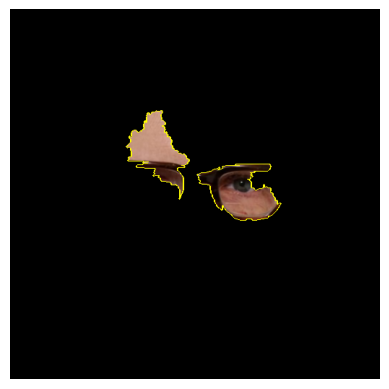

In [21]:
explanation = explainer.explain_instance(
    image=glass_image_np,
    classifier_fn=batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=True,
    num_features=5,
    min_weight=0.0
)
lime_img_glass = mark_boundaries(temp / 255.0, mask)
plt.axis('off')
plt.imshow(lime_img_glass)

**Interpretation**: LIME highlights the most influential superpixels that contributed positively to the model’s decision.Only the parts of glass and eye area is highlighted showing classificarion as glass image.

  0%|          | 0/1000 [00:00<?, ?it/s]

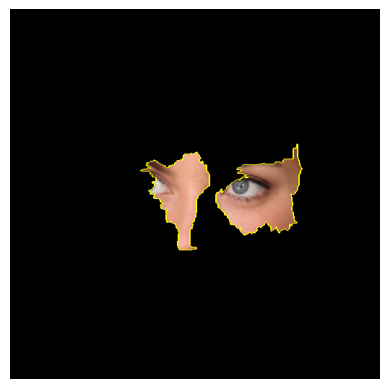

In [22]:
explanation = explainer.explain_instance(
    image=noglass_image_np,classifier_fn=batch_predict,top_labels=2,hide_color=0,num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],positive_only=True,hide_rest=True,num_features=5,min_weight=0.0
)

lime_img_noglass = mark_boundaries(temp / 255.0, mask)
plt.axis('off')
plt.imshow(lime_img_noglass)

**Interpretation**: LIME confirms model focuses on areas where glasses should be. Here absence is interpreted by absence of structure.

**3. Integrated Gradient**

**Integrated Gradients** explain a model’s prediction by measuring how each pixel contributes, relative to a baseline (like a black image).
It attributes importance to pixels that change the prediction most when moving from baseline to the actual image.

In [23]:
from captum.attr import IntegratedGradients

In [24]:
ig = IntegratedGradients(model)

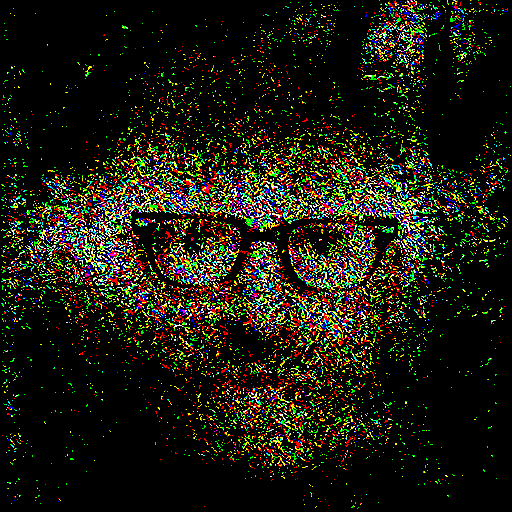

In [25]:
glass_res = ig.attribute(glass_input_tensor, target=1)
to_pil(glass_res[0])

Shows sharp attribution around the glasses. The face and background remain noisy but less relevant.

**Interpretation**: This technique attributes most importance to the shape and contrast edges of the glasses.

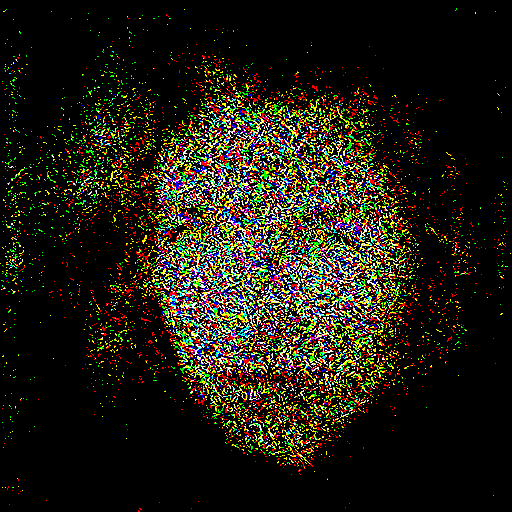

In [26]:
noglass_res = ig.attribute(noglass_input_tensor, target=1)
to_pil(noglass_res[0])

The colored pixel clusters around face indicating these regions most influenced the model’s prediction.

**4. Occulation Technique**

Occlusion analysis helps identify which parts of the image, when hidden, significantly affect the model's prediction.

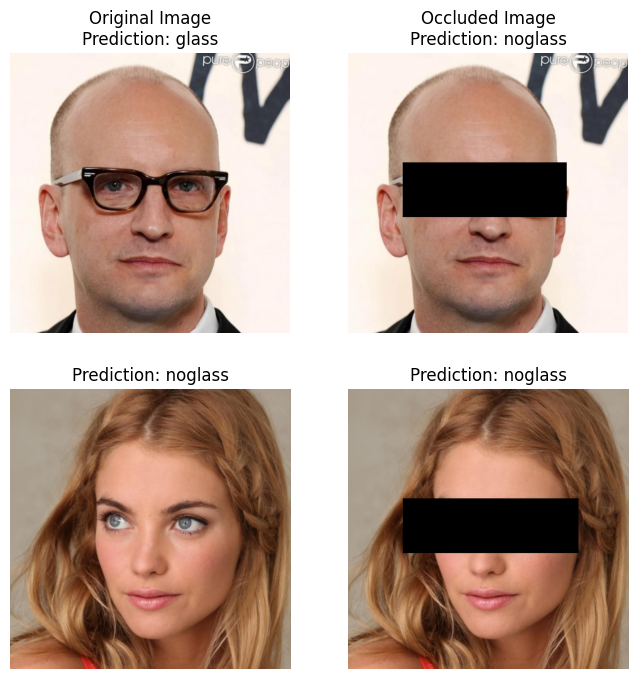

In [51]:
to_tensor = transforms.ToTensor()
glass_original_image = glass_image_np
glass_original_output = model(to_tensor(glass_original_image).unsqueeze(0).to(device))

noglass_original_image = noglass_image_np
noglass_original_output = model(to_tensor(noglass_original_image).unsqueeze(0).to(device))

# Display the original
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(glass_original_image, cmap='gray')
plt.title(f"Original Image\nPrediction: {class_name[glass_original_output.max(1)[1].item()]}")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(noglass_original_image, cmap='gray')
plt.title(f"Prediction: {class_name[noglass_original_output.max(1)[1].item()]}")
plt.axis('off')


# Define the size of the square for occlusion and its position
occlusion_size = 100
square_x = 100
square_y = 200
glass_occluded_image = glass_image_np.copy()
glass_occluded_image[square_y:square_y+occlusion_size, square_x:square_x+occlusion_size+200] = 0
glass_occluded_output = model(to_tensor(glass_occluded_image).unsqueeze(0).to(device))

noglass_occluded_image = noglass_image_np.copy()
noglass_occluded_image[square_y:square_y+occlusion_size, square_x:square_x+occlusion_size+220] = 0
noglass_occluded_output = model(to_tensor(noglass_occluded_image).unsqueeze(0).to(device))


# Display the occluded images
plt.subplot(2, 2, 2)
plt.imshow(glass_occluded_image, cmap='gray')
plt.title(f"Occluded Image\nPrediction: {class_name[glass_occluded_output.max(1)[1].item()]}")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(noglass_occluded_image, cmap='gray')
plt.title(f"Prediction: {class_name[noglass_occluded_output.max(1)[1].item()]}")
plt.axis('off')

plt.show()

Original image has glass and the model correctly predicted it as 'glass'. When the glasses area is occluded, the model's prediction changes to 'no glass', indicating the importance of the glasses for the classification. Similarly, the original image without glasses is correctly predicted as 'no glass', and the prediction remains 'no glass' when a region is occluded.

**Comparison of XAI methods**

Grad-CAM highlights overall regions of interest, helping visualize where the model directs its focus.

LIME provides targeted explanations by analyzing the impact of specific masked-out sections.

Integrated Gradients reveals detailed pixel-wise influence, showing how each pixel affects the prediction.

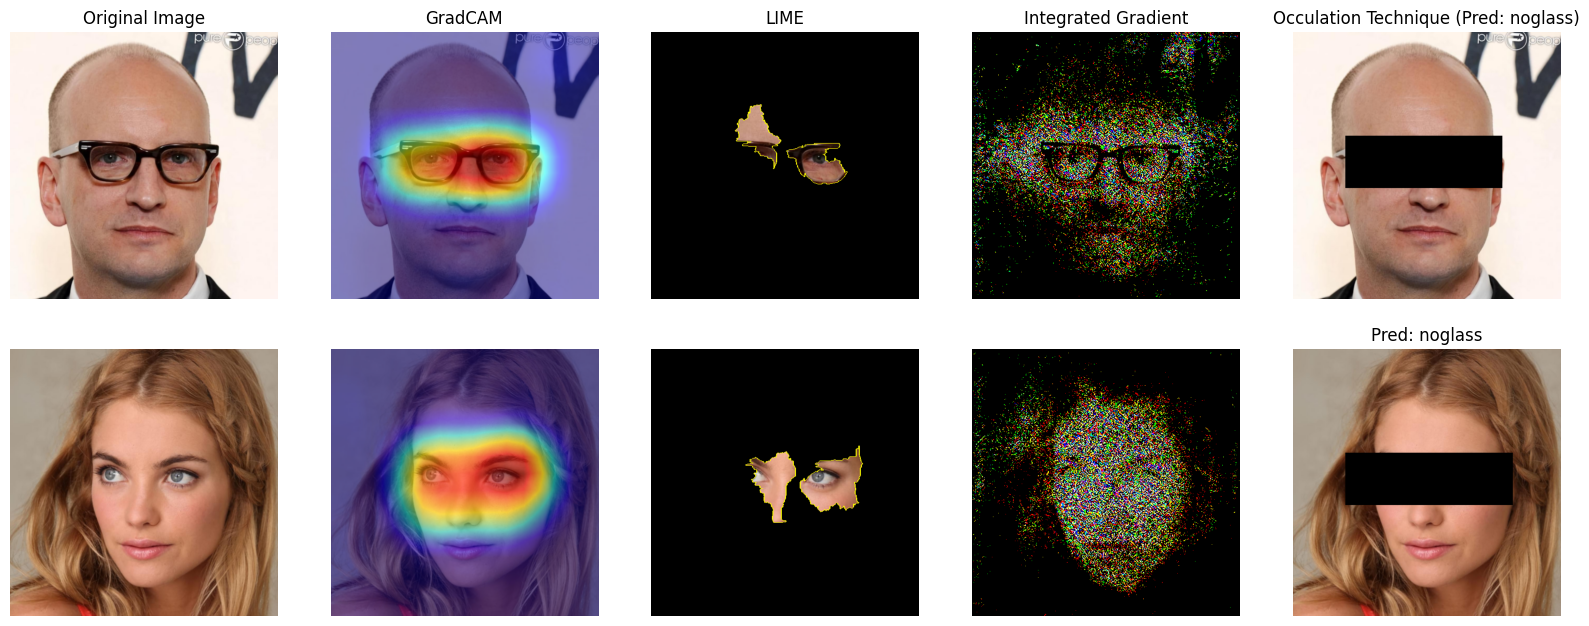

In [50]:
def plot_image(subplot_index, image, title):
    plt.subplot(2, 5, subplot_index)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')


plt.figure(figsize=(20, 10))

plot_image(1, glass_image, "Original Image")
plot_image(2, visualization_glass, "GradCAM")
plot_image(3, lime_img_glass, "LIME")
plot_image(4, to_pil(glass_res[0]), "Integrated Gradient")
plot_image(5, glass_occluded_image, f"Occulation Technique (Pred: {class_name[glass_occluded_output.max(1)[1].item()]})")
plot_image(6, noglass_image, "")
plot_image(7, visualization_noglass, "")
plot_image(8, lime_img_noglass, "")
plot_image(9, to_pil(noglass_res[0]), "")
plot_image(10, noglass_occluded_image, f"Pred: {class_name[noglass_occluded_output.max(1)[1].item()]}")

plt.subplots_adjust(hspace=-0.3)

plt.show()

Comparing XAI methods
* **GradeCAM**
Clearly highlights the glasses frame region around the eyes and nose bridge. And the for image with no glasses focuses on eyes and forehead where glasses would typically appear.

* **LIME**
Precisely segments and highlights only the glasses, isolating their influence. And for image with no glasses, it highlights eye region and skin where glasses are expected.

* **Integrated Gradients**
Shows dense attribution over the entire glasses structure, even pixel-wise. This indicates glasses' color contrast and contours are crucial for the model.For images with no glasses, pixel-level attention is spread over eyes and facial contour, with no clear structure.

* **Occulation Technique**
Blocking the eye+glasses region leads to misclassification (no-glasses) — this shows how critical that region is.

# **LLM Disclosure**


Parts of this report were or refined with the help of a large language model (LLM), specifically ChatGPT by OpenAI.